In [1]:
import IPython
from pvrecorder import PvRecorder
import wave
import struct
import time
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import wandb

In [2]:
recorder = PvRecorder(device_index=0, frame_length=512)
sound = []

recorder.start()
print('recording')
t_0 = time.time()
while time.time()-t_0<4:
    frame = recorder.read()
    sound.extend(frame)
        # Do something ...
recorder.stop()
recorder.delete()
fs = 16000


recording


In [3]:
path = 'test.wav' 
with wave.open(path, 'w') as f:
                    f.setparams((1, 2, fs, 512, "NONE", "NONE"))
                    f.writeframes(struct.pack("h" * len(sound), *sound))

In [4]:
data = np.array(sound).astype(np.int16)
for i in range(100):
    fft = np.fft.fft(data)*0.1
    data = np.fft.ifft(fft)
    data = ((2**(16-4)) * data/data.max()).astype(np.int16)
   

/var/folders/q8/9dhs6y4d21s87vxtnwqflq5m0000gn/T/ipykernel_89120/534606777.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  data = ((2**(16-4)) * data/data.max()).astype(np.int16)


In [5]:
data = np.array(sound).astype(np.int16)
fft = np.fft.fft(data)
fft

array([-16757737.             +0.j        ,
         -135839.30295385-147497.34922677j,
         -164858.91537085-291262.32565593j, ...,
          -41693.57867003+236245.17605371j,
         -164858.91537085+291262.32565593j,
         -135839.30295385+147497.34922677j])

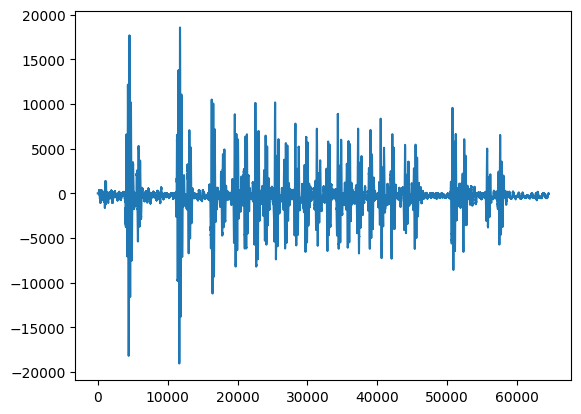

In [6]:
plt.plot(data)

/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


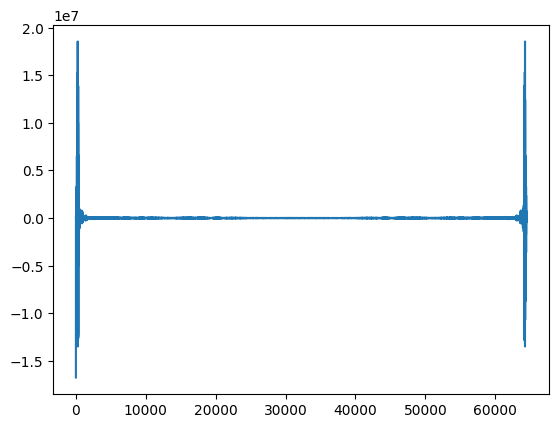

In [7]:
plt.plot(fft)
  

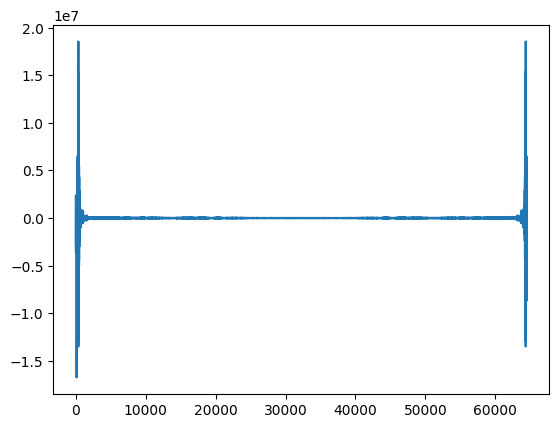

In [8]:
roll = np.roll(fft,100)
plt.plot(roll)

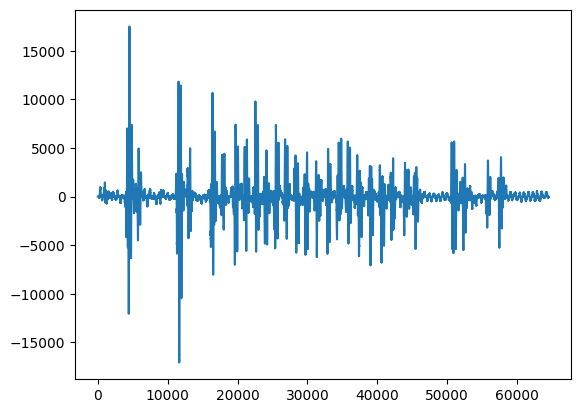

In [9]:
ifft = np.fft.ifft(roll)
plt.plot(ifft)

In [10]:
fft

array([-16757737.             +0.j        ,
         -135839.30295385-147497.34922677j,
         -164858.91537085-291262.32565593j, ...,
          -41693.57867003+236245.17605371j,
         -164858.91537085+291262.32565593j,
         -135839.30295385+147497.34922677j])

In [11]:
roll = np.roll(fft,10)
data = np.fft.ifft(roll)
data = ((2**(16-4)) * data/data.max()).astype(np.int16)

/var/folders/q8/9dhs6y4d21s87vxtnwqflq5m0000gn/T/ipykernel_89120/3895190541.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  data = ((2**(16-4)) * data/data.max()).astype(np.int16)


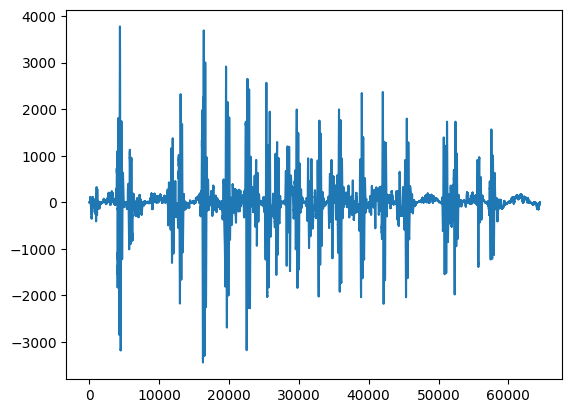

In [12]:
plt.plot(data*0.9)

In [13]:
!env | grep env

PYENV_ROOT=/Users/fridadesigley/.pyenv
VIRTUAL_ENV=/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico
PYENV_VIRTUAL_ENV=/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico
PATH=/Users/fridadesigley/.pyenv/versions/pico/bin:/usr/local/opt/pyenv/libexec:/usr/local/opt/pyenv/plugins/python-build/bin:/Users/fridadesigley/google-cloud-sdk/bin:/opt/homebrew/bin:/Users/fridadesigley/.pyenv/shims:/usr/local/Cellar/pyenv-virtualenv/1.1.5/shims:/usr/local/bin:/usr/local/sbin:/Users/fridadesigley/.pyenv86/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/local/sbin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/Apple/usr/bin
PYENV_HOOK_PATH=/Users/fridadesigley/.pyenv/pyenv.d:/usr/local/opt/pyenv/pyenv.d:/usr/local/etc/pyenv.d:/etc/pyenv.d:/usr/lib/pyenv/hooks:/Users/fridadesigley/.pyenv/plugins/pyenv-alias/etc/pyenv.d
_=/usr/bin/env


In [14]:
from scipy.io.wavfile import read
import wave
import struct
import ipywidgets as widgets
import IPython
from pvrecorder import PvRecorder
import wave
import struct
import time
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [15]:
duration = 1000000  # seconds
fs = 16000
myrecording = sd.rec(duration * fs, samplerate=fs, channels=1)

In [16]:
myrecording

array([[-0.00162337],
       [-0.00236033],
       [-0.00132801],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [17]:
class Response:
    def __init__(self,frame):
        self.frame_length=frame
        self.path =  './test.wav'
        self.t_delta=1
        self.fs = 16000
        self.root = Path('./')
        
    def set_time(self,delta_sec:int):
        self.t_delta=delta_sec
    
    def createdirs(self):
        if not self.dir.exists():
            self.dir.mkdir(exist_ok=True)
        for sound_class in self.class_dirs:
            sound_dir = self.dir/sound_class
            sound_dir.mkdir(exist_ok=True)

            
    def get_classes(self,sound_classes:tuple[str,str]):
        self.dir = self.root/'data'  
        self.class_dirs = sound_classes
        self.createdirs()
        self.classes={sound:{'class':idx,'count':len(list((self.dir/sound).iterdir()))} for idx,sound in enumerate(sound_classes)}
        print(self.classes)
        self.set_widgets()
        
        
    def set_widgets(self):
        
        actions=[
            widgets.Button(description=f'record {name}') for name,entry in self.classes.items()]
        for act in actions:
            act.on_click(self.record)
            
            
        save = widgets.Button(description='save \U0001F4BE')
        play = widgets.Button(description='play ▶️')
        
        delete = widgets.Button(description='delete \U0000274C')
        save.on_click(self.save)
        play.on_click(self.play)
        delete.on_click(self.drop_recording)
        self.out = widgets.Output()
        actions+=[play,save,delete,self.out]
        acts = tuple(actions)
        self.vbox=widgets.VBox(children=acts)
        display(self.vbox)
        
    def record(self,button:widgets.Button):
        with self.out:
            key = button.description.split(' ')[1]
            self.state = key
            self.classes[key]['count']+=1
            self.classes[key][f'record {self.classes[key]["count"]}']=np.array([])
#             print(dir(self.out))
#             print(self.out._Output__counter)
            self.recorder = PvRecorder(device_index=0, frame_length=self.frame_length)
            self.recorder.start()
            t_0 = time.time()
            record = np.array([]).astype(np.int16)
            while time.time()-t_0<self.t_delta:
                frame = self.recorder.read()
                record = np.append(record,np.array(frame)).astype(np.int16)
            self.recorder.stop()
            self.recorder.delete()
            self.classes[key][f'record {self.classes[key]["count"]}']=record
            

    def save(self,_):
        path = self.root/'data'
        if not path.exists():
            path.mkdir(exist_ok=True)
        with self.out:
            for state in self.classes:
                class_dir = path/state
                if not class_dir.exists():
                    class_dir.mkdir(exist_ok=True)
                for key in self.classes[state]:
                    if 'record' in key:
                        rec = self.classes[state][key]
                        fid = class_dir/f'{state}_{key}.wav'
                        with wave.open(str(fid), 'w') as f:
                            f.setparams((1, 2, self.fs, 512, "NONE", "NONE"))
                            f.writeframes(struct.pack("h" * len(rec), *rec))
        
    def play(self,_):
        try:
            count = self.classes[self.state]['count']
            print(self.classes[self.state][f'record {count}'])
            for key in self.classes[self.state]:
                if 'record' in key:
                    sd.play(self.classes[self.state][key], self.fs)
                    sd.wait()
        except(KeyError,AttributeError):
            print('no recordings')

    def drop_recording(self,_):
        try:
            if self.classes[self.state]['count']!=0:
                self.classes[self.state].popitem()
                self.classes[self.state]['count']-=1
        except(KeyError,AttributeError):
            print('no recordings')

In [18]:
sample = Response(frame=512)
sample.set_time(delta_sec=1)
sample.get_classes(('yes','no','background'))


{'yes': {'class': 0, 'count': 15}, 'no': {'class': 1, 'count': 5}, 'background': {'class': 2, 'count': 0}}


In [19]:
!tree data

data
├── background
├── no
│   ├── no_record 1.wav
│   ├── no_record 2.wav
│   ├── no_record 3.wav
│   ├── no_record 4.wav
│   └── no_record 5.wav
└── yes
    ├── yes_record 1.wav
    ├── yes_record 10.wav
    ├── yes_record 11.wav
    ├── yes_record 12.wav
    ├── yes_record 13.wav
    ├── yes_record 14.wav
    ├── yes_record 15.wav
    ├── yes_record 2.wav
    ├── yes_record 3.wav
    ├── yes_record 4.wav
    ├── yes_record 5.wav
    ├── yes_record 6.wav
    ├── yes_record 7.wav
    ├── yes_record 8.wav
    └── yes_record 9.wav

3 directories, 20 files


In [20]:
import wave
import numpy as np
import matplotlib.pyplot as plt
def read_wav(fid:str):
    # Read file to get buffer                                                                                               
    ifile = wave.open(fid)
    samples = ifile.getnframes()
    audio = ifile.readframes(samples)

    # Convert buffer to float32 using NumPy                                                                                 
    audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
    return audio_as_np_int16

In [21]:
!pwd

/Users/fridadesigley/pico/tiny-ml


In [23]:
#  !mkdir datasets
#  !wget 'https://github.com/karoldvl/ESC-50/archive/master.zip' -P ~/pico/audio-classifier/datasets
#  !unzip -q ~/datasets/master.zip -d ./datasets/

In [24]:
import pandas as pd
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

df = pd.read_csv(esc50_csv)
df.head(100)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
95,1-20133-A-39.wav,1,39,glass_breaking,False,20133,A
96,1-202111-A-3.wav,1,3,cow,False,202111,A
97,1-20545-A-28.wav,1,28,snoring,False,20545,A
98,1-20736-A-18.wav,1,18,toilet_flush,False,20736,A


In [25]:
import tensorflow as tf
import tensorflow_io as tfio

/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/tensorflow_io/python/ops/

In [26]:
sample_rate = 16000
chans = 1
sound = read_wav('./data/yes/yes_record 3.wav')
sound = sound.astype(np.float32, order='F') / 32768.0


In [27]:
file_contents = tf.io.read_file('./data/yes/yes_record 5.wav')
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=chans)
squeeze_wav = tf.squeeze(wav, axis=-1)
spect = tf.signal.stft(squeeze_wav, frame_length=512, frame_step=128)


In [28]:
wav

<tf.Tensor: shape=(16384, 1), dtype=float32, numpy=
array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [-0.00704956],
       [-0.00631714],
       [-0.00570679]], dtype=float32)>

In [29]:
import scipy

In [30]:
import cmsisdsp
from numpy import pi as PI

window_size = 512
step_size = 64

hanning_window_f32 = np.zeros(window_size)
for i in range(window_size):
  hanning_window_f32[i] = 0.5 * (1 - cmsisdsp.arm_cos_f32(2 * PI * i / window_size ))
hanning_window_q15 = cmsisdsp.arm_float_to_q15(hanning_window_f32)
rfftq15 = cmsisdsp.arm_rfft_instance_q15()
status = cmsisdsp.arm_rfft_init_q15(rfftq15, window_size, 0, 1)

def get_arm_spectrogram(waveform):
  num_frames = int(1 + (len(waveform) - window_size) // step_size)
  fft_size = int(window_size // 2 + 1)
  # Convert the audio to q15
  waveform_q15 = cmsisdsp.arm_float_to_q15(waveform)
  # Create empty spectrogram array
  spectrogram_q15 = np.empty((num_frames, fft_size), dtype = np.int16)
  start_index = 0
  for index in range(num_frames):
    # Take the window from the waveform.
    window = waveform_q15[start_index:start_index + window_size]
    # Apply the Hanning Window.
    window = cmsisdsp.arm_mult_q15(window, hanning_window_q15)
    # Calculate the FFT, shift by 7 according to docs
    window = cmsisdsp.arm_rfft_q15(rfftq15, window)
    # Take the absolute value of the FFT and add to the Spectrogram.
    spectrogram_q15[index] = cmsisdsp.arm_cmplx_mag_q15(window)[:fft_size]
    # Increase the start index of the window by the overlap amount.
    start_index += step_size
  # Convert to numpy output ready for keras
  return cmsisdsp.arm_q15_to_float(spectrogram_q15).reshape(num_frames,fft_size) * 512

In [31]:
spct = get_arm_spectrogram(wav)

In [32]:
spect

<tf.Tensor: shape=(125, 257), dtype=complex64, numpy=
array([[-1.1825697e+00+0.0000000e+00j,  7.9305696e-01-3.3905774e-02j,
        -2.6453486e-01-1.7655689e-01j, ...,
         8.3236247e-03-5.0675496e-03j, -7.6637864e-03+3.2727597e-03j,
         5.6102276e-03+0.0000000e+00j],
       [-1.1571851e+00+0.0000000e+00j,  5.1088202e-01+7.2440378e-02j,
         8.9413024e-02+5.3528726e-02j, ...,
        -2.6634298e-03-8.3412975e-05j,  4.6035647e-03+5.5335462e-03j,
        -3.3004284e-03+0.0000000e+00j],
       [-1.1590379e+00+0.0000000e+00j,  5.0499785e-01-6.7214325e-02j,
         3.9693721e-02-8.3785877e-02j, ...,
        -2.0413008e-03+1.2983121e-03j,  4.9695969e-03-2.0664409e-03j,
        -7.0039034e-03+0.0000000e+00j],
       ...,
       [-1.9084167e+00+0.0000000e+00j,  1.0758590e+00+9.9544629e-02j,
        -1.5023670e-01-7.5578287e-02j, ...,
         5.2796602e-03+1.4986992e-03j, -6.4264536e-03-7.1737394e-03j,
         4.9974322e-03+0.0000000e+00j],
       [-1.7120256e+00+0.0000000e+00j,

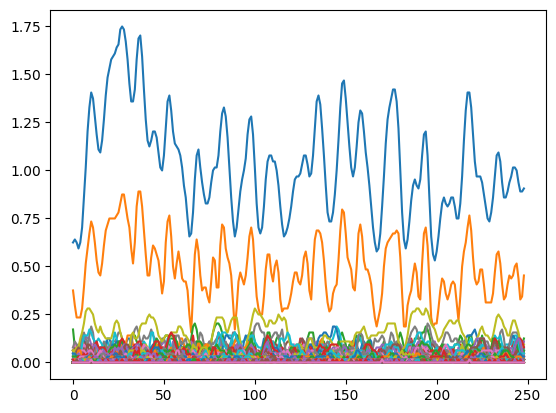

In [33]:
plt.plot(spct)

In [34]:
!pip install pydub

In [35]:
fid = "./datasets/ESC-50-master/audio/1-100032-A-0.wav"
# times between which to extract the wave from
start = 0 # seconds
end = 1 # seconds

def segment(fid:str, chunk:int):
    # file to extract the snippet from
    data = [ ]
    with wave.open(fid, "rb") as infile:
        # get file data
        nchannels = infile.getnchannels()
        sampwidth = infile.getsampwidth()
        framerate = infile.getframerate()
        # set position in wave to start of segment
        for sec in range(4):
            infile.setpos(int(sec * framerate))
            data.append(infile.readframes(chunk * framerate))   
    return data, (nchannels, sampwidth , framerate)
        

In [36]:
data = segment(fid = "./datasets/ESC-50-master/audio/1-100032-A-0.wav",
       chunk=1)

in_paranet = Path('./datasets/ESC-50-master/audio/')
out_data_dir = Path('ESC-50')
out_data_dir.mkdir(exist_ok=True)
all_out = [ ]
for idx, row in df.iterrows():
    out_dir = out_data_dir/row.category
    out_dir.mkdir(exist_ok=True)
    data, vals = segment(fid = str(in_paranet/row.filename),
       chunk=1)
    chans, samp_width , rate = vals
    out_fids = [ ]
    for idx,sound in enumerate(data):
        out_fid = out_dir/f'{idx}_{row.filename}'
        out_fids.append(out_fid)
        with wave.open(str(out_fid), 'w') as outfile:
            outfile.setnchannels(chans)
            outfile.setsampwidth(samp_width)
            outfile.setframerate(rate)
            outfile.setnframes(int(len(sound) /  samp_width))
            outfile.writeframes(sound)
    all_out.append(out_fids)
        
    
    
    

In [37]:
sec_files = np.array(all_out).astype(str)
for files in range(sec_files.shape[-1]):
    df[f'{files}_{files+1}_sec']=sec_files[...,files].astype(str)

In [38]:
columns = list(df.columns)

In [39]:
table = wandb.Table(data=df,columns=columns)

In [40]:
for col in df.columns[-4:]:
    sounds = [wandb.Audio(fid) for fid in df[col].values]
    table.add_column(name=f'sound_{col}',data=sounds)

In [41]:
run = wandb.init(entity='tiny-ml',project = 'wake_word_detection')

wandb: Currently logged in as: frds (tiny-ml). Use `wandb login --relogin` to force relogin


In [42]:
run.log({'all_sound_table':table})


In [43]:
run.finish()

wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.



# Data table for sound Wandb table with 

> 1. ouriginal sound string
> 2. playable sound file
> 3. 4 * 1 second clips files
> 4  4 * 1 second clips files

# Sound and Spectrogram Table



In [44]:
fid = df[0:1].all_out.values[0][2]
file_contents = tf.io.read_file(str(fid))
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=chans)

AttributeError: 'DataFrame' object has no attribute 'all_out'

In [56]:
spct = get_arm_spectrogram(wav)

<tf.Tensor: shape=(249, 257), dtype=float32, numpy=
array([[0.625   , 0.375   , 0.171875, ..., 0.      , 0.      , 0.      ],
       [0.640625, 0.296875, 0.078125, ..., 0.      , 0.      , 0.      ],
       [0.625   , 0.234375, 0.03125 , ..., 0.015625, 0.015625, 0.      ],
       ...,
       [0.890625, 0.328125, 0.078125, ..., 0.      , 0.      , 0.      ],
       [0.890625, 0.34375 , 0.09375 , ..., 0.      , 0.      , 0.      ],
       [0.90625 , 0.453125, 0.125   , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)>

In [57]:
np.std(spct)

0.6403931

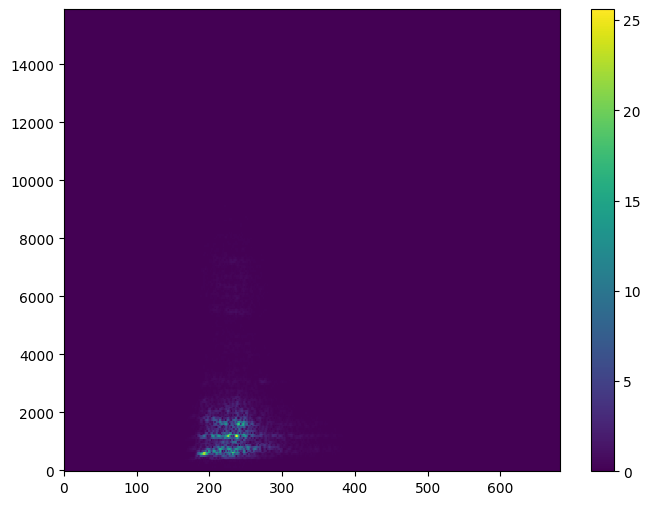

In [58]:

def plot_spectrogram(spectrogram,sample_rate, vmax=None):
  transposed_spectrogram = tf.transpose(spectrogram)

  fig = plt.figure(figsize=(8,6))
  height = transposed_spectrogram.shape[0]
  X = np.arange(transposed_spectrogram.shape[1])
  Y = np.arange(height * int(sample_rate / 256), step=int(sample_rate / 256))

  im = plt.pcolormesh(X, Y, tf.transpose(spectrogram), vmax=vmax)

  fig.colorbar(im)
  plt.show()


plot_spectrogram(spct,16000)

In [50]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = 1
# Sampling rate is the number of samples of audio recorded every second
DIRECTORY = './datasets/ESC-50-master/audio/'
SAMPLING_RATE = 16000
BATCH_SIZE = 32  # Batch-size for training and evaluating our model.
NUM_CLASSES = 10  # Number of classes our dataset will have (11 in our case).
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = MAX_DURATION * SAMPLING_RATE  # Maximum length of the input audio file.
# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = 49
MAX_EPOCHS = 2  # Maximum number of training epochs.

MODEL_CHECKPOINT = "facebook/wav2vec2-base"  # Name of pretrained model from Hugging Face Model Hub

In [52]:
!ls './datasets/ESC-50-master/audio/'

1-100032-A-0.wav  2-118624-A-30.wav 3-151212-A-24.wav 4-196671-A-8.wav
1-100038-A-14.wav 2-118625-A-30.wav 3-151213-A-24.wav 4-196671-B-8.wav
1-100210-A-36.wav 2-118817-A-32.wav 3-151255-A-28.wav 4-196672-A-8.wav
1-100210-B-36.wav 2-118964-A-0.wav  3-151269-A-35.wav 4-197103-A-6.wav
1-101296-A-19.wav 2-119102-A-21.wav 3-151273-A-35.wav 4-197454-A-28.wav
1-101296-B-19.wav 2-119139-A-31.wav 3-151557-A-28.wav 4-197454-B-28.wav
1-101336-A-30.wav 2-119161-A-8.wav  3-151557-B-28.wav 4-197871-A-15.wav
1-101404-A-34.wav 2-119161-B-8.wav  3-152007-A-20.wav 4-198025-A-23.wav
1-103298-A-9.wav  2-119161-C-8.wav  3-152007-B-20.wav 4-198360-A-49.wav
1-103995-A-30.wav 2-119748-A-38.wav 3-152007-C-20.wav 4-198360-B-49.wav
1-103999-A-30.wav 2-120218-A-30.wav 3-152007-D-20.wav 4-198360-C-49.wav
1-104089-A-22.wav 2-120218-B-30.wav 3-152007-E-20.wav 4-198841-A-37.wav
1-104089-B-22.wav 2-120333-A-32.wav 3-152020-A-36.wav 4-198962-A-25.wav
1-105224-A-22.wav 2-120586-A-6.wav  3-152020-B-36.wav 4-198962-B-25.

Found 0 files belonging to 0 classes.


ValueError: No audio files found in directory ./datasets/ESC-50-master/audio/. Allowed format(s): ('.wav',)

In [50]:
input_shape = tf.expand_dims(spct, axis=-1).shape
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()

Model

In [51]:
baseline_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=input_shape),
  tf.keras.layers.experimental.preprocessing.Resizing(32, 32, interpolation="nearest"), 
  norm_layer,
  tf.keras.layers.Conv2D(8, kernel_size=(8,8), strides=(2, 2), activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(50, activation='softmax')
])

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 8)         520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 8)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dropout (Dropout)           (None, 288)               0

In [53]:
baseline_model.predict(spct)

2023-01-20 17:28:54.761006: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/fridadesigley/.pyenv/versions/3.9.7/envs/pico/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 249, 257, 1), found shape=(None, 257)


In [ ]:
EPOCHS = 250
history = baseline_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=callbacks,
)